# Integrating Product Design and Supply Chain Design

## Import Packages

In [468]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc;

## Parameters

In [469]:
numAssemblyOptions = 2
numSuppliersPerPart = 2

In [470]:
components = [1, 2]
componentsForSubsystems = {}
subsystemsForComponents = {}
assembliesStructure = {1 : [], 
                       2 : []}
assemblyNodes = list(assembliesStructure.keys())
finalNodes = [3]
allNodes = components + assemblyNodes + finalNodes
nonComponentNodes = assemblyNodes + finalNodes
print(components)
print(allNodes)

[1, 2]
[1, 2, 1, 2, 3]


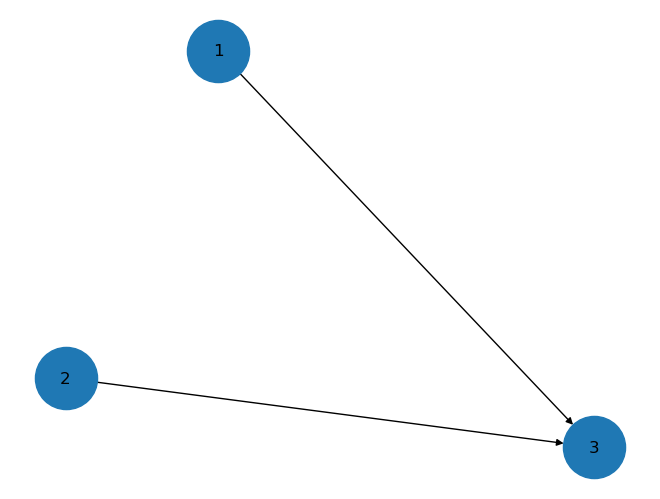

In [471]:
G = nx.DiGraph()

numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

np.random.seed(0)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for n in allNodes:
    time = np.random.randint(1, 4)
    if n in finalNodes:
        maxTime = 0
    else:
        maxTime = 100
    G.add_node(n, process_time=time, 
               max_service_time_out=maxTime,
               stage_cost=np.random.randint(1, 6))

for n in assemblyNodes:
    for component in assembliesStructure[n]:
        G.add_edge(component, n)

for n in assemblyNodes:
    for n2 in finalNodes:
        G.add_edge(n, n2)

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(G, 'process_time')
stageCostDict = nx.get_node_attributes(G, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

nx.draw(G, with_labels=True, node_size=2000)
plt.show()

In [472]:
safetyFactor = 1.645
sigma = 3
holdingCostRate = 0.2

In [473]:
def getMaxReplenishmentTime(n : int):
    if n in components:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(i) for i in G.predecessors(n)])
    
def getCumCost(n : int):
    if n in components:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(i) for i in G.predecessors(n)])

maxReplenishmentTime = {n : getMaxReplenishmentTime(n) for n in allNodes}
cumCost = {n : getCumCost(n) for n in allNodes}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,2,3,3,100,2
1,2,1,1,1,100,1
2,3,1,5,9,0,3


In [474]:

def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn(node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if node in finalNodes:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal + 1)

def get_sOut_range(node : int, sIn : int = 0):
    return range(sIn + processTimesDict[node]+ 1)

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def create_dp_graph(G : nx.DiGraph, sourcePerComponent : bool = True):
    dp_G = nx.DiGraph()
    dp_G.add_node('t')
    if not sourcePerComponent:
        dp_G.add_node('s')
    for n in finalNodes:
        for sIn in get_sIn_range_for_g_fn(n):
            nodeTupleIn = str(n) + "_" + str(sIn)
            dp_G.add_node(nodeTupleIn)
        for sOut in get_sOut_range_for_g_fn(n, 0):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            dp_G.add_edge(nodeTupleOut, 't', time = 0, time_reduce = 0,
                          cost = 0)
            for sIn in get_sIn_range_for_g_fn(n):
                nodeTupleIn2 = str(n) + "_" + str(sIn)
                dp_G.add_edge(nodeTupleIn2, nodeTupleOut, 
                              time = sOut - sIn,
                              time_reduce = 0,
                              cost = getHoldingCost(n, sIn, sOut))
    for n in components:
        sIn = 0
        nodeTupleIn = str(n) + "_" + str(sIn)
        dp_G.add_node(nodeTupleIn)
        #dp_G.add_edge('s', nodeTupleIn, time = 0, time_reduce = 0, cost = 0)
        for sOut in get_sOut_range(n):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                          time = sOut - sIn, 
                          time_reduce = sOut - (sIn + processTimesDict[n]),
                          cost = getHoldingCost(n, sIn, sOut))
            for finalNode in finalNodes:
                finalNodeTupleIn = str(finalNode) + "_" + str(sOut)
                dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, time_reduce = 0,
                              time = 0, cost = 0)
    return dp_G

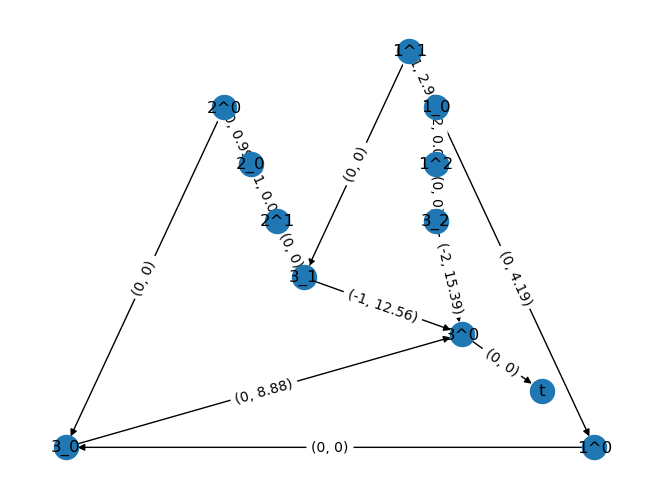

In [475]:
dp_G = create_dp_graph(G)

pos = nx.planar_layout(dp_G)
nx.draw(dp_G, pos, with_labels=True)
edge_labels = {(u, v): (data['time'], round(data['cost'],2)) 
               for u, v, data in dp_G.edges(data=True)}
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [476]:
for n in components:
    path = nx.shortest_path(dp_G, str(n) + '_0', 't', weight='cost')
    path_length = nx.shortest_path_length(dp_G, str(n) + '_0', 't', weight='cost')
    print("Cost", path_length)
    print("path", path)

Cost 13.070486358186736
path ['1_0', '1^0', '3_0', '3^0', 't']
Cost 9.870000000000001
path ['2_0', '2^0', '3_0', '3^0', 't']


In [477]:
# dp_G_neg = dp_G.copy()
# for u, v, data in dp_G_neg.edges(data=True):
#     data['time'] = -data['time']

# pos = nx.kamada_kawai_layout(dp_G_neg)
# nx.draw(dp_G_neg, pos, with_labels=True)
# edge_labels_neg = {(u, v): (data['time'], round(data['cost'],1)) 
#                for u, v, data in dp_G_neg.edges(data=True)}
# nx.draw_networkx_edge_labels(dp_G_neg, pos, edge_labels=edge_labels_neg)
# plt.show()

In [478]:
path = nx.shortest_path(dp_G_neg, 's', 't', weight='time')
path_length = nx.shortest_path_length(dp_G_neg, 's', 't', weight='time')
print("Total lead time", path_length)
print("path", path)

NodeNotFound: Either source s or target t is not in G

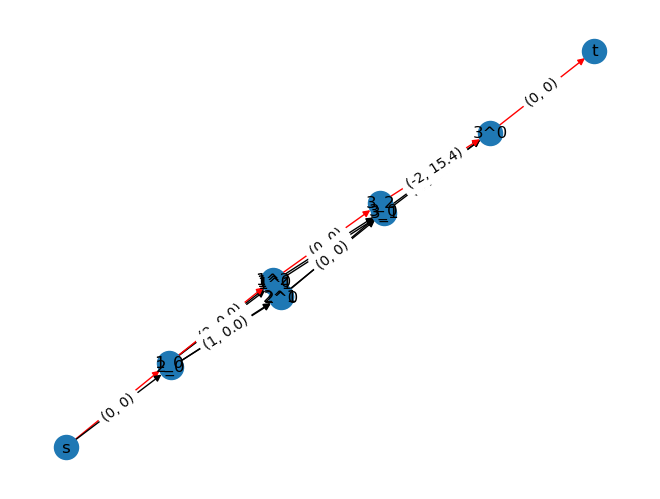

In [ ]:
edgesUsed = [(path[i], path[i+1]) for i in range(len(path)-1)]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
def getNetFlowExpr(G, x, node, netflow : list[int]):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node)) 

In [ ]:
# Create a new model
m = gp.Model("shortest_path")

x = m.addVars(dp_G_neg.edges(), name="x")
y = m.addVars(dp_G_neg.edges(), name="y")

m.setObjective(gp.quicksum(x[e]*dp_G_neg.edges[e]['cost'] for e in dp_G_neg.edges()), 
               GRB.MINIMIZE)

for n in components:
    m.addConstr(qsum(x[e] for e in dp_G_neg.out_edges(str(n) + "_0")) <= 1, "component " + str(n) + " sIn-sOut")

m.addConstr(gp.quicksum(x[e]*dp_G_neg.edges[e]['time'] for e in dp_G_neg.edges()) <= 0, "pathLengthLimit")

netflow = {n : 0 for n in dp_G_neg.nodes()}
netflow['s'] = 1
netflow['t'] = -1
m.addConstrs((getNetFlowExpr(dp_G_neg, x, n, netflow) == netflow[n] for n in dp_G_neg.nodes()), "netflow")
# for v in dp_G_neg.nodes():
#     if v == 's':
#         m.addConstr(qsum(x[e] for e in dp_G_neg.out_edges(v)) - qsum(x[e] 
#                                                                      for e in dp_G_neg.in_edges(v)) == 1,
#                                                                       "net flow at " + str(v))
#     elif v == 't':
#         m.addConstr(qsum(x[e] for e in dp_G_neg.out_edges(v)) - qsum(x[e] 
#                                                                      for e in dp_G_neg.in_edges(v)) == -1, "net flow at " + str(v))
#     else:
#         m.addConstr(qsum(x[e] for e in dp_G_neg.out_edges(v)) - qsum(x[e] 
#                                                                                    for e in dp_G_neg.in_edges(v)) == 0, "net flow at " + str(v))

m.optimize()

xVals = [x[e].x for e in dp_G_neg.edges() if x[e].x > 0.0]

edgesUsed = [e for e in dp_G_neg.edges() if x[e].x > 0.0]
times = [-dp_G_neg.edges[e]['time'] for e in edgesUsed]
costs = [dp_G_neg.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'X': xVals,
    'Time': times,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print(df)

dualMultipliers = [c.Pi for c in m.getConstrs()]

df = pd.DataFrame({
    'Constraint': [c.ConstrName for c in m.getConstrs()],
    'Dual multiplier': dualMultipliers
})
df

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 22.4.0 22E252)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 16 rows, 32 columns and 42 nonzeros
Model fingerprint: 0x97f3392a
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 16 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8700000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.870000000e+00
    Edge used    X  Time Holding cost
0  (3_0, 3^0)  1.0     0        $8.88
1    (3^0, t)  1.0     0        $0.00
2    (s, 2_0)  1.0     0        $0.00
3  (2_0, 2^0)  1.0     0        $0.99
4  (2^0, 3_0)  1.0     0        $0.00


,Constraint,Dual multiplier
0,component 1 sIn-sOut,0.000000
1,component 2 sIn-sOut,0.000000
2,pathLengthLimit,0.000000
3,netflow[t],-9.870000
4,netflow[3_0],-0.987000
5,netflow[3_1],2.692459
6,netflow[3_2],5.515807
7,netflow[3^0],-9.870000
8,netflow[1_0],0.000000
9,netflow[s],0.000000


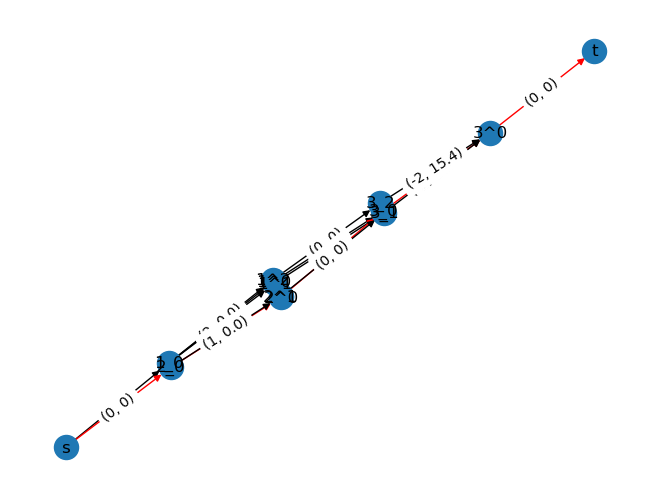

In [ ]:
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
# def getServiceTimeIn(node : int, path : list):
#     if node in components:
#         return 0
#     else:
#         for sIn in range(0,max([maxReplenishmentTime[n] for n in components])+1):
#             if (node, sIn, 0) in path:
#                 return sIn
            
# def getServiceTimeOut(node : int, path : list):
#     if node == finalNode:
#         return 0
#     else:
#         for sOut in range(0,processTimesDict[node]+1):
#             if (node, 0, sOut) in path:
#                 return sOut


# df = pd.DataFrame({
#     'Node': maxReplenishmentTime.keys(),
#     'Process time': processTimes,
#     'Stage cost': stageCostDict.values(),
#     'Cumulative cost': cumCost.values(),
#     'maxReplenishmentTime': maxReplenishmentTime.values(),
#     'Service time in': [getServiceTimeIn(node, path) for node in range(0,3)],
#     'Service time out': [getServiceTimeOut(node, path) for node in range(0,3)],
#     'Holding cost': [getHoldingCost(node, getServiceTimeIn(node, path), 
#                                     getServiceTimeOut(node, path)) for node in range(0,3)]
# })
# df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
# df

In [ ]:
# def isFeasibleForNode(node : int, sIn : int, sOut : int):
#     if sIn + processTimesDict[node] - sOut >= 0:
#         return True
#     else:
#         return False

# m = gp.Model("Network")

# z = m.addVar(name = "final")

# x = m.addVars([finalNode], get_sIn_range_for_g_fn(finalNode), [0], name = "x")
# y = m.addVars(procureNodes, get_sIn_range_for_g_fn(finalNode), name = "y")

# m.update()
# print(x)
# print(y)

# m.addConstrs((z <= x[finalNode, sIn, 0] for sIn in get_sIn_range_for_g_fn(finalNode)), 
#               name = "lastMin")

# m.addConstrs((x[finalNode, sIn, 0] == getHoldingCost(finalNode, sIn, 0) + qsum(y[n,sIn] for n in pred[finalNode])
#               for sIn in get_sIn_range_for_g_fn(finalNode) if isFeasibleForNode(n, 0, sIn)), 
#              name = "sum")

# for n in procureNodes:
#     for sIn in get_sIn_range_for_g_fn(finalNode):
#         if isFeasibleForNode(n, 0, sIn):
#             print(n, sIn, getHoldingCost(n, 0, sIn) )
        
# m.addConstrs((y[n, sIn] == getHoldingCost(n, 0, sIn) 
#               for sIn in get_sIn_range_for_g_fn(finalNode) 
#               for n in procureNodes if isFeasibleForNode(n, 0, sIn)))

# m.setObjective(z, GRB.MINIMIZE)
# m.optimize()

# for v in m.getVars():
#     print(v.varName, v.X)